# Computational modeling : A basic Active Inference agent


In [2]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

from functools import partial

# The environment is statically defined by its HMM matrices : 
from simulate.hmm_weights import behavioural_process

# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop,generate_synthetic_data
# To fit the models :
from simulate.compute_likelihood import compute_loglikelihood,fit
from simulate.compute_likelihood import fit_mle_agent,fit_map_agent

import tensorflow_probability.substrates.jax.distributions as tfd

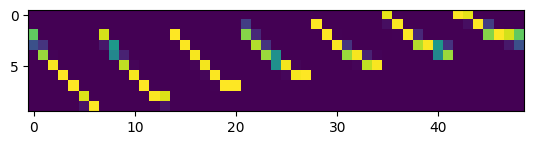

In [3]:
# The virtual environment  ENVIRONMENTAL CONSTANTS :
T = 11
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)
rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

plt.imshow(a[0])

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


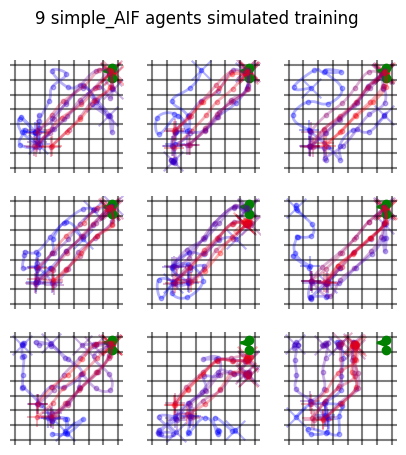

In [9]:
from agents import simple_aif_1D



N_TRIALS = 10


# We get a model weights by defining a "parameters" object :
static_params = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions" :9,
    
    "Th" : 2,
    
    "learn_e" : True
}

TRUE_PARAMS = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 5.0,
    "state_interpolation_temperature" : 0.3,
        
    "feedback_expected_std" : 0.25,
    
    "reward_seeking" : 10.0,
    
    "habits_learning_rate" : 0.05,
    
    "action_selection_temperature" : 10.0
}
N_hyperparams = len(TRUE_PARAMS)



aif_priors = {
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : uninformed priors
    "transition_stickiness": tfd.Uniform(low=-0.01,high=1000.0),
    "transition_learning_rate" : tfd.Uniform(low=-0.01,high=1000.0),
    "state_interpolation_temperature" : tfd.Uniform(low=-0.01,high=1000.0),
        
    "feedback_expected_std" : tfd.Uniform(low=-0.0,high=1000.0),
    
    "reward_seeking" :tfd.Normal(10.0,10.0),
    
    "habits_learning_rate" : tfd.Uniform(low=-0.01,high=1000.0),
    
    "action_selection_temperature" : tfd.Normal(10.0,5.0), # Expecting a rather well informed choice
}


_aif_1d_agent = partial(simple_aif_1D,constants=static_params)


from simulate.plot_trajectory import plot_training
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 simple_AIF agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,_aif_1d_agent(TRUE_PARAMS),SEED,N_TRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


# DATA = generate_synthetic_data(ENVIRONMENT,_aif_1d_agent(TRUE_PARAMS),N_TRIALS,0)
# # # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
# opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(DATA,_aif_1d_agent,N_hyperparams,
#                                                                                   aif_priors,
#                                                                                   jr.PRNGKey(10),true_hyperparams=TRUE_PARAMS,
#                                                                                   num_steps=250,n_iter=20,
#                                                                                   verbose=True)
